In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
import survaeflow
import survaeflow.transform.stochastic as stochastic
from survaeflow.distribution.normal import Normal

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

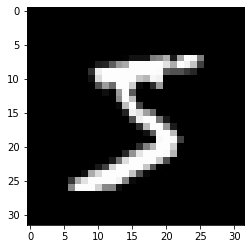

In [5]:
x = np.pad(
    x_train, [[0, 0], [2, 2], [2, 2]],
    'constant', constant_values=0)
x = x.astype(np.float32) / 127.5 - 1.
plt.imshow(x[0], cmap='gray')

In [6]:
BATCHSIZE = 128
dataset = tf.data.Dataset.from_tensor_slices(x) \
    .shuffle(128) \
    .batch(BATCHSIZE)
dataset

<BatchDataset shapes: (None, 32, 32), types: tf.float32>

In [7]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(4, 3, 2, padding='same'),  # [16, 16, 4]
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(8, 3, 2, padding='same'),  # [8, 8, 8],
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(16, 3, 2, padding='same'), # [4, 4, 16],
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(32, 3, 2, padding='same'), # [2, 2, 32],
            tf.keras.layers.ReLU(),
            tf.keras.layers.Flatten(),  # [128]
            tf.keras.layers.Dense(64),  # [64]
        ])
    def call(self, data):
        # data: [B, 32, 32]
        # [B, 64]
        latent = self.model(data[..., None])
        # [B, 32], [B, 32]
        mu, log_sigma = tf.split(latent, 2, axis=-1)
        return mu, log_sigma

class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(64),  # [32]
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dense(128),  # [128]
            tf.keras.layers.ReLU(),
            tf.keras.layers.Reshape([2, 2, 32]),  # [2, 2, 32]
            tf.keras.layers.Conv2DTranspose(16, 3, 2, padding='same'),  # [4, 4, 16]
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2DTranspose(8, 3, 2, padding='same'),  # [8, 8, 8]
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2DTranspose(4, 3, 2, padding='same'),  # [16, 16, 4]
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2DTranspose(1, 3, 2, padding='same'),  # [32, 32, 1]
            tf.keras.layers.Activation('tanh')
        ])
    def call(self, latent):
        # latent: [B, 32]
        # [B, 32, 32]
        return tf.squeeze(self.model(latent), axis=-1)

In [8]:
flow = survaeflow.Flow(
    prior=Normal(0.), networks=[stochastic.VAE(Encoder(), Decoder())])
optim = tf.keras.optimizers.Adam(0.001)
writer = tf.summary.create_file_writer('./log/vae')

In [9]:
step = 0
for _ in tqdm(range(15)):
    with tqdm(total=x.shape[0] // BATCHSIZE, leave=False) as pbar:
        for batch in dataset:
            with tf.GradientTape() as tape:
                _, log_prob = flow(batch)
                loss = -tf.reduce_mean(log_prob)

            grad = tape.gradient(loss, flow.trainable_variables)
            optim.apply_gradients(zip(grad, flow.trainable_variables))

            step += 1
            pbar.update()
            pbar.set_postfix({
                'step': step,
                'loss': loss.numpy().item()})
            
            with writer.as_default():
                tf.summary.scalar('loss', loss, step=step)

        latent = flow.forward(batch)
        resample = flow.inverse(latent)

        with writer.as_default():
            tf.summary.image('gt', batch[0:1, ..., None], step=step)
            tf.summary.image('rctor', resample[0:1, ..., None], step=step)


In [10]:
[i for i, y in enumerate(y_train) if y == 9][:10]

[4, 19, 22, 33, 43, 45, 48, 54, 57, 80]

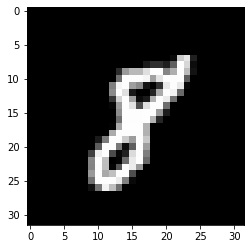

In [11]:
# 0 1 2 3 4 5  6  7  8 9
# 1 3 5 7 2 0 13 15 17 4
plt.imshow(x[17], cmap='gray')

In [22]:
latent = flow.forward(x[[5, 7]])

In [23]:
scale = 5
disc_latent = (latent[1] - latent[0]) / scale

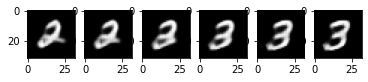

In [24]:
l = latent[0]
for i in range(scale + 1):
    img = flow.inverse(l[None])
    plt.subplot(1, scale + 1, i + 1)
    plt.imshow(img[0].numpy(), cmap='gray')
    l += disc_latent